In [274]:
import pandas as pd
import os, sys
import ujson, re
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from src.DataReader import DataReader
from src.constants import SPLIT_TIME, STORE_LOCATION, DATA_ROOT, POSTS_FILE, VOTES_FILE
from operator import itemgetter

In [257]:
%matplotlib inline

In [23]:
emb_root = '/Users/prmathur/Documents/Pers/MMDS/Course/CS224W/Project/snap-master/examples/node2vec/emb/'

In [4]:
data_directory = DATA_ROOT

In [2]:
train_df = pd.read_csv(os.path.join(STORE_LOCATION, 'train.csv'))

In [5]:
post_reader = DataReader(os.path.join(data_directory, POSTS_FILE), True)
post_reader.read_data()

Reading file...
Converting...
Progress | ██████████ | 100% || Estimated time remaining: 0.0 seconds
Conversion complete...
Forming data frame...


In [6]:
pdf = post_reader._df

In [14]:
q_tags_df = pdf[pdf.PostTypeId==1][['Id', 'Tags']]

In [17]:
train_df = train_df.merge(q_tags_df, how='left', left_on='QuestionId', right_on='Id', suffixes=('_tr', '_qt'))

In [21]:
train_df[['QuestionId', 'AcceptedAnswerUserId', 'UsersSorted', 'Tags']].head()

,QuestionId,AcceptedAnswerUserId,UsersSorted,Tags
0,5.0,45.0,"[45.0, 1102.0, 48.0, 226.0, 242.0]","[elementary-number-theory, proof-writing, radi..."
1,1.0,8.0,"[8.0, 49.0, 25.0, 35.0, 39.0]","[elementary-set-theory, intuition, faq]"
2,8.0,38.0,"[38.0, 173.0, 334.0, 53.0, 55.0]","[linear-algebra, combinatorics, generating-fun..."
3,2.0,34.0,"[34.0, 56.0, 35.0, 190287.0, 72.0]","[calculus, limits, definition]"
4,20.0,38.0,"[38.0, 72.0, 232.0, 51.0, 210.0]","[terminology, definition, number-systems]"


In [36]:
indx2tag_dict = {}
tag2index_dict = {}
with open(os.path.join(STORE_LOCATION, 'graphs/user-tag_keys.txt')) as tg_fl:
    for row in tg_fl:
        k, v = row.strip().split(',')
        indx2tag_dict[float(v.strip())] = k
        tag2index_dict[k] = float(v.strip())

In [124]:
# print model.syn0[model.vocab['10000958'].index].shape
# print model.index2word[169]

(128,)
10000958


In [84]:
def get_user_vals(users):
    return re.findall(r'[{]*(\d+).0', users)

In [226]:
def get_rep(row, model):
    tags = row.Tags
    tag_id = [str(int(tag2index_dict[t])) for t in tags]
    w2v_idx = [model.vocab[t].index for t in tag_id]
    t_vectors = model.syn0[w2v_idx]
    q = t_vectors.mean(axis=0)
    
    accepted_user = str(int(row.AcceptedAnswerUserId))
    user_vec = {}

    output = None
    
    users = get_user_vals(row.UsersSorted)
    for u in users:
        user = str(int(u))
        op_row = None
        
        if user in model.vocab:
            user_w2v_idx = model.vocab[user].index
            user_vector = model.syn0[user_w2v_idx]
        else:
            user_vector = np.zeros(128)
        
        if user == accepted_user:
            op_row = np.hstack((q, user_vector, 1))
        else:
            op_row = np.hstack((q, user_vector, 0))
            
        if output is None:
            output = op_row
        else:
            output = np.vstack((output, op_row))

    return output

In [227]:
temp = get_rep(train_df.ix[0], model)

In [238]:
ut_files = [f for f in os.listdir(emb_root) if 'ut' in f]

In [250]:
for emb_file in ut_files:
    model = Word2Vec.load_word2vec_format(os.path.join(emb_root, emb_file), binary=False)
    print 'Loaded {}\n'.format(emb_file)
    
    train_ds = []
    for indx, row in train_df.iterrows():
        temp_set = get_rep(row, model)
        train_ds.append(temp_set)
        
        if indx % 1000 == 0:
            sys.stdout.write('.')
            sys.stdout.flush()

    train_ds = np.vstack(train_ds)
    
    print '\nBegin CV'
    clf = LogisticRegression(n_jobs=-1)
    scores = cross_val_score(clf, train_ds[:, :256], train_ds[:, 256], cv=5)

    p, q = emb_file.replace('.emb', '').replace('ut_', '').split('-')
    print '{0}; {1} : Accuracy - {2}'.format(p, q, np.mean(scores))

Loaded ut_p0.25-q0.25.emb

................
Begin CV
p0.25; q0.25 : Accuracy - 0.799620155078
Loaded ut_p0.25-q0.50.emb

................
Begin CV
p0.25; q0.50 : Accuracy - 0.799696116463
Loaded ut_p0.25-q1.emb

................
Begin CV
p0.25; q1 : Accuracy - 0.799873384545
Loaded ut_p0.25-q2.emb

................
Begin CV
p0.25; q2 : Accuracy - 0.799721450551
Loaded ut_p0.25-q4.emb

................
Begin CV
p0.25; q4 : Accuracy - 0.799797414342
Loaded ut_p0.50-q0.25.emb

................
Begin CV
p0.50; q0.25 : Accuracy - 0.799746762196
Loaded ut_p0.50-q0.50.emb

................
Begin CV
p0.50; q0.50 : Accuracy - 0.79974676941
Loaded ut_p0.50-q1.emb

................
Begin CV
p0.50; q1 : Accuracy - 0.799835400244
Loaded ut_p0.50-q2.emb

................
Begin CV
p0.50; q2 : Accuracy - 0.799999997275
Loaded ut_p0.50-q4.emb

................
Begin CV
p0.50; q4 : Accuracy - 0.799683468656
Loaded ut_p1-q0.25.emb

................
Begin CV
p1; q0.25 : Accuracy - 0.799620155078
Loaded ut

In [271]:
perf_df = pd.DataFrame([(0.25, 0.25, 0.799620155078), (0.25, 0.50, 0.799696116463), (0.25, 1, 0.799873384545), 
          (0.25, 2, 0.799721450551), (0.25, 4, 0.799797414342), (0.50, 0.25, 0.799746762196), 
          (0.50, 0.50, 0.79974676941), (0.50, 1, 0.799835400244), (0.50, 2, 0.799999997275), 
          (0.50, 4, 0.799683468656), (1, 0.25, 0.799620155078), (1, 0.50, 0.799835393832), (1, 1, 0.79988604678), 
          (1, 2, 0.799734110382), (1, 4, 0.799164368325), (2, 0.25, 0.799746771815), (2, 0.50, 0.799810082188), 
          (2, 1, 0.799784746496), (2, 2, 0.799962014578), (2, 4, 0.800012657906), (4, 0.25, 0.799911367242), 
          (4, 0.50, 0.799848061678), (4, 1, 0.799645480349), (4, 2, 0.799708774691), (4, 4, 0.79988604197)])

In [272]:
perf_df.columns = ['p', 'q', 'Accuracy']

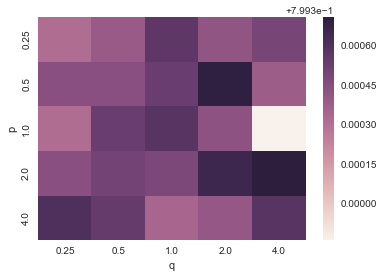

In [277]:
# plt.figure(figsize=(10, 10))
ax = sns.heatmap(perf_df.pivot('p', 'q', 'Accuracy'))

array([ 0.,  1.])

In [278]:
clf.fit(train_ds[:, :256], train_ds[:, 256])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [282]:
clf.score(train_ds[:, :256], train_ds[:, 256])

0.79989870853380607